### 4. Political analysis : Does speaking mean acting?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import geopandas

### 1. Loading the Data

In [5]:
#read the data (pickle files containing climate-change related quotes), for the first time, then save to pickle
#data2020=pd.read_pickle("data2020.pkl", compression='infer')
#data2019=pd.read_pickle("data2019.pkl", compression='infer')
#data2018=pd.read_pickle("data2018.pkl", compression='infer')
#data2017=pd.read_pickle("data2017.pkl", compression='infer')
#data2016=pd.read_pickle("data2016.pkl", compression='infer')
#data2015=pd.read_pickle("data2015.pkl", compression='infer')

#data15_16=data2015.append(data2016, ignore_index = True)
#data16_17=data15_16.append(data2017, ignore_index = True)
#data17_18=data16_17.append(data2018, ignore_index = True)
#data19=data17_18.append(data2019, ignore_index=True)
#data_climate=data19.append(data2020, ignore_index=True)
#data_climate.to_pickle("./data_climate.pkl")

In [7]:
data_climate=pd.read_pickle("data_climate.pkl", compression='infer')

In [183]:
## Subset of the climate quotes containing specific meaningful words
data_crisis=data_climate[data_climate['quotation'].str.contains('Crisis|crisis')]

data_economic=data_climate[data_climate['quotation'].str.contains('economic|economy|Economy|Economic|business')]

In [9]:
#read QID csv
QID = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [12]:
#read parquet file
speaker_df = pd.read_parquet("speaker_attributes.parquet", engine='pyarrow')

In [13]:
#removing duplicates on 'label'
speaker_df=speaker_df.drop_duplicates(subset=['label'])

### How political parties talking about climate change? 
1. How are the parties represented in this climate quotes dataset?


In [14]:
#sort speakers from the one with the most quotes to the least
sorted_speakers=data_climate['speaker'].value_counts().to_frame('counts').reset_index()
sorted_speakers = sorted_speakers.rename(columns={'index': 'label'})


In [15]:
#merge classement above and the parquet file
top_speakers_inorder = pd.merge(sorted_speakers, speaker_df, how='left', on='label')

In [16]:
#Get the infos in the QID file
party=top_speakers_inorder[['party','counts']]
party=party.explode(column='party')
party = party.rename(columns={'party': 'QID'})
party=party.dropna()

#counts number of occurence of each QID label for the party
party=party.groupby(['QID'])['counts'].sum().to_frame()
party=party.sort_values(by='counts',ascending=False)


In [17]:
final=pd.merge(party, QID, on='QID')
final=final.sort_values(by='counts',ascending=False)

## take only parties from the USA
final=final.dropna()
final=final[final['Description'].str.contains('United States')]

## group minorities in categorie 'others'
other = final.loc[final['counts']<300].sum()
final=final[final['counts'] > 300]
final=final.append(other, ignore_index=True)
final.at[2,'Label']='Others'
final

,counts,Label,Description
0,7824,Democratic Party,political party in the United States
1,2426,Republican Party,major political party in the United States
2,144,Others,"political party in Minnesota, United Statesfir..."


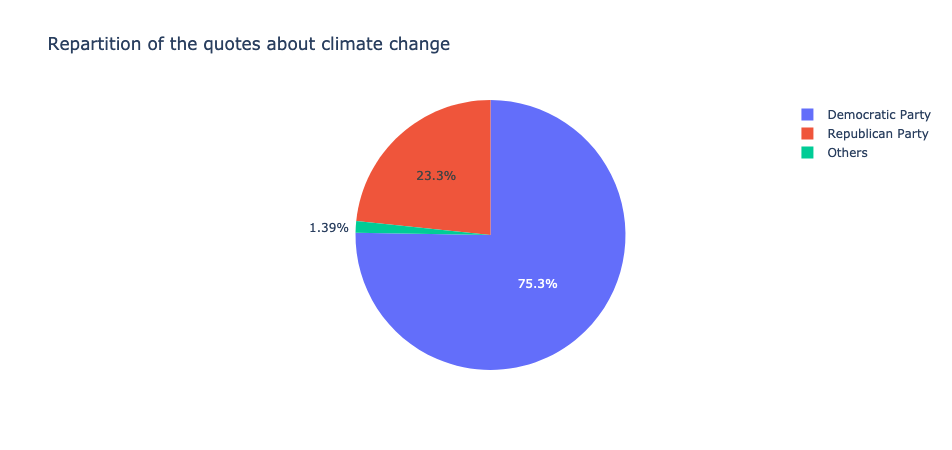

In [195]:
import plotly.graph_objects as go

labels = final['Label']
values = final['counts']

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Repartition of the quotes about climate change',width=450, height=450)
fig.show()
fig.write_html("pie_chart.html")

2. Which proportion of democrates/republican quotes contains specific meaningful words?

The goal here is to see which proportion some words from the LDA topics founds above take in the climate dataset. We choose to tackle the first 2 topics. From the first one, we use the word 'crisis' and for the second one 'business'.

In [293]:
#crisis
sorted_speakers_crisis=data_crisis['speaker'].value_counts().to_frame('counts').reset_index()
sorted_speakers_crisis = sorted_speakers_crisis.rename(columns={'index': 'label'})

top_speakers_crisis = pd.merge(sorted_speakers_crisis, speaker_df, how='left', on='label')

In [294]:
#business
sorted_business=data_economic['speaker'].value_counts().to_frame('counts').reset_index()
sorted_business = sorted_business.rename(columns={'index': 'label'})

top_speakers_business = pd.merge(sorted_business, speaker_df, how='left', on='label')

In [295]:
party_crisis=top_speakers_crisis[['party','counts']]
party_crisis=party_crisis.explode(column='party')
party_crisis = party_crisis.rename(columns={'party': 'QID'})
party_crisis=party_crisis.dropna()

party_crisis=party_crisis.groupby(['QID'])['counts'].sum().to_frame()
party_crisis=party_crisis.sort_values(by='counts',ascending=False)




In [296]:
party_business=top_speakers_business[['party','counts']]
party_business=party_business.explode(column='party')
party_business = party_business.rename(columns={'party': 'QID'})
party_business=party_business.dropna()

party_business=party_business.groupby(['QID'])['counts'].sum().to_frame()
party_business=party_business.sort_values(by='counts',ascending=False)



In [297]:
final_crisis=pd.merge(party_crisis, QID, on='QID')
final_crisis=final_crisis.sort_values(by='counts',ascending=False)


In [298]:
final_business=pd.merge(party_business, QID, on='QID')
final_business=final_business.sort_values(by='counts',ascending=False)


In [299]:
business_crisis=pd.merge(final_crisis, final_business, on='Description')

In [300]:
bar=pd.merge(business_crisis, final, on='Description')


In [301]:
bar['percentage_crisis']=bar['counts_x']/bar['counts']
bar['percentage_business']=bar['counts_y']/bar['counts']

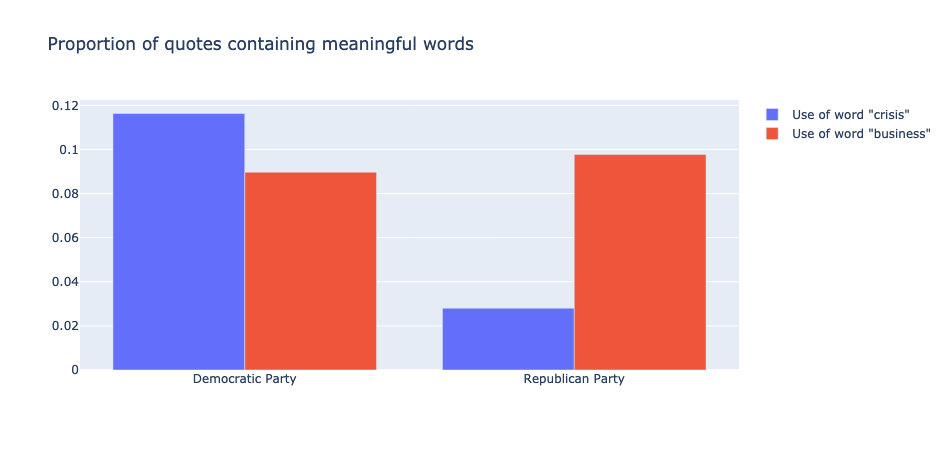

In [305]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    y=bar['percentage_crisis'],
    x=bar['Label_x'],
    name='Use of word "crisis"',
   
    )
)
fig.add_trace(go.Bar(
   y=bar['percentage_business'],
   x=bar['Label_x'],
   name='Use of word "business"',
    
)
             )
  


fig.update_layout(barmode='group', width=520, height=450, title='Proportion of quotes containing meaningful words')
fig.show()
fig.write_html("bar_chart_words.html")

### Score of durability of each state

We aim to get an idea of the actions taken agains global warming for each state in the US. We use here dataset containing an environmental index for each state https://www.governing.com/next/what-is-the-greenest-most-environmentally-friendly-state.html. This is a report from WalletHub from 2021 that gives an environmental score to  each state based on three criterias: environmental quality, eco-friendly behavior and climate-change contributions.

In [29]:
#read file containing durability score
scores=pd.read_csv('states_scores.csv', delimiter=';')

#normalize values too be able to compare with other datas later
max_value = scores['score'].max()
min_value = scores['score'].min()
scores['score'] = (scores['score'] - min_value) / (max_value - min_value)

In [83]:
#creating the map using geopandas and a shapefile of the US
states = geopandas.read_file('data/usa-states-census-2014.shp')
states=states.rename(columns={'NAME': 'state'})
states=states.to_crs(epsg=3395)

#merge with states_scores
geo_scores=pd.merge(states, scores, how='left', on='state')


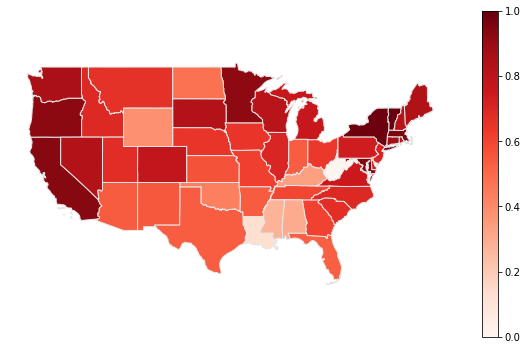

In [84]:
#plot map with geopandas
fig, ax = plt.subplots(1, figsize=(10,6))
geo_scores.plot(column='score', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
plt.show()

### CO2 emissions of each state
Co2 emissions are another indicator of the state actions against global warming. We use there the CO2 per capita (in metric tons) for each state. The data comes from The World ressource institute, and the most recent values we could find are from 2018. https://www.wri.org/data/climate-watch-historical-emissions-data-countries-us-states-unfccc

In [278]:
emissions=pd.read_csv('emissions.csv', delimiter=',')
emissions=emissions.rename(columns={'Climate Watch - U.S States Greenhouse Gas Emissions':'date', 'Unnamed: 1':'total','Unnamed: 20':'Population'}) 
emissions.drop(emissions.index[:3], inplace=True)


In [270]:
#emissions per capita
emissions['Co2_cap']=emissions['total'].astype(float)/emissions['Population'].astype(float)
emissions.reset_index(inplace=True)
emissions=emissions.rename(columns={'index':'state'})

In [271]:
emissions_2018=emissions[emissions['date']=='2018']


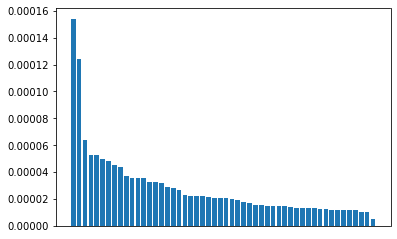

In [272]:
#visualisation of the distribution
bar=emissions_2018.sort_values(by='Co2_cap',ascending=False).reset_index()



plt.bar(bar.index, bar['Co2_cap'])
plt.xticks([])
plt.show()

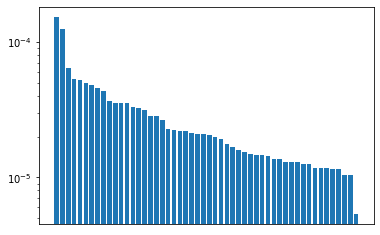

In [273]:
#visualisation of the distribution in log-scale


plt.bar(bar.index, bar['Co2_cap'], log=True)
plt.xticks([])
plt.show()


In [274]:
#Use log-value
emissions_2018['log_co2'] = np.log(emissions_2018['Co2_cap'].replace(0, np.nan))



/var/folders/jr/t14p4dwd3bs3vxwk5cbfgjb80000gn/T/ipykernel_40330/4080072826.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [275]:
max_value = emissions_2018['log_co2'].max()
min_value = emissions_2018['log_co2'].min()
emissions_2018['log_co2_norm'] = (emissions_2018['log_co2'] - min_value) / (max_value - min_value)

/var/folders/jr/t14p4dwd3bs3vxwk5cbfgjb80000gn/T/ipykernel_40330/488144107.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [276]:
#merge with states_scores
geo_co2=pd.merge(states, emissions_2018, how='left', on='state')


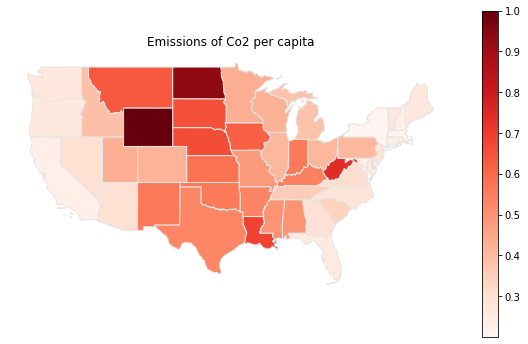

In [277]:
#plot map with geopandas
fig, ax = plt.subplots(1, figsize=(10,6))
geo_co2.plot(column='log_co2_norm', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
ax.set_title('Emissions of Co2 per capita')
plt.show()

### Representing the absolute number of quotes about global warming of each state using the governors of each state as reference

In [113]:
#read file containing governors' names
governors=pd.read_csv('governors.csv', delimiter=';')


governors=governors.dropna(how='all')
governors = governors.rename(columns={'name': 'label', 'party':'political_party', 'state_name':'state'})
governors=governors[['state', 'label', 'political_party']]

In [114]:
#sort the governors from the one with the most quotes to the less
governors_quotes = pd.merge(governors, sorted_speakers, how='left', on='label')


In [115]:
governors_quotes.isna().sum()


state               0
label               0
political_party     0
counts             25
dtype: int64

many NAN values: governors are not present enough in quotebank, we can not use them to represent the states

### Number of quotes of each state but using senators as reference

In [116]:
#read file containing senators names
senators=pd.read_csv('senators.csv', delimiter=';')

senators=senators.rename(columns={'Name': 'label', 'State':'state'})
senators=senators[['label','state']]

In [117]:
#sort senators from the one with the most quotes to the least
senators_quotes = pd.merge(senators, sorted_speakers, how='left', on='label')
# group them by state
senators_quotes_grouped=senators_quotes.groupby(['state'])['counts'].sum().to_frame()


In [118]:
##checking if all states are represented
senators_quotes_grouped.isna().sum()


counts    0
dtype: int64

We have now a better representation of the states

### Combining senators and governors

In [119]:
total=senators_quotes.append(governors_quotes)
total=total.groupby(['state'])['counts'].sum().to_frame()


/var/folders/jr/t14p4dwd3bs3vxwk5cbfgjb80000gn/T/ipykernel_40330/1041006334.py:6: MatplotlibDeprecationWarning:

Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.



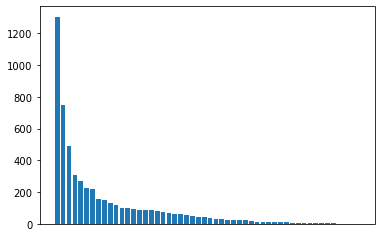

In [120]:
#visualisation of the distribution
bar=total.sort_values(by='counts',ascending=False)


plt.bar(bar.index, bar['counts'])
plt.xticks([])
plt.show()

We have a heavy tail distribution so it would be nice see the result with a log-scale

/var/folders/jr/t14p4dwd3bs3vxwk5cbfgjb80000gn/T/ipykernel_40330/3621098548.py:5: MatplotlibDeprecationWarning:

Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.



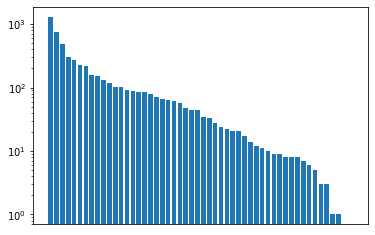

In [126]:

#visualisation of the distribution using a log-scale
bar=total.sort_values(by='counts',ascending=False)

plt.bar(bar.index, bar['counts'], log=True)
plt.xticks([])
plt.show()

In [127]:
## use a logarithm value to represent data
total['log_abs'] = np.log(total['counts'].replace(0, np.nan))

#normalize between 0 and 1
max_value = total['log_abs'].max()
min_value = total['log_abs'].min()
total['log_abs_norm'] = (total['log_abs'] - min_value) / (max_value - min_value)


In [123]:
geo_quotes=pd.merge(states, total, how='left', on='state')


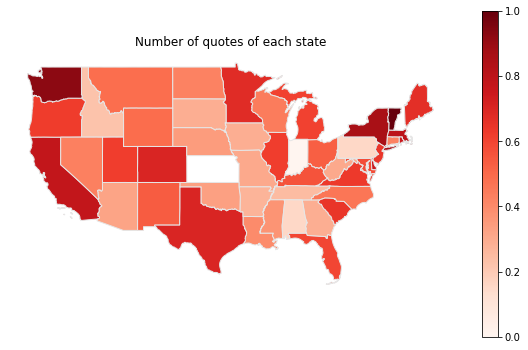

In [124]:
fig, ax = plt.subplots(1, figsize=(10,6))
geo_quotes.plot(column='log_abs_norm', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
ax.set_title('Number of quotes of each state')
plt.show()

### Relative number of quotes about global warming of each states

To get the relative number of quotes of each states, we use the number of quotes about global warming found above and divide it by total the number of quotes (all quotes).

In [ ]:
#data2020=pd.read_json('quotes-2020.json.bz2', lines=True, compression='bz2')
#data2019=pd.read_json('quotes-2019.json.bz2', lines=True, compression='bz2')
#data2018=pd.read_json('quotes-2018.json.bz2', lines=True, compression='bz2')
#data2017=pd.read_json('quotes-2017.json.bz2', lines=True, compression='bz2')
#data2016=pd.read_json('quotes-2016.json.bz2', lines=True, compression='bz2')
#data2015=pd.read_json('quotes-2015.json.bz2', lines=True, compression='bz2')

#frame = [data2020, data2019, data2018, data2017, data2016, data2015]

#data_tot = pd.DataFrame()

#for df in frame:
#    data_tot = data_tot.append(df)
#data_tot_speakers=data_tot['speaker'].to_frame()

#data_tot_speakers.to_pickle("./total_quotes.pkl")

In [129]:
#read pickle
data=pd.read_pickle("total_quotes.pkl", compression='infer')


In [135]:
# senators + governors
all_speakers=senators_quotes.append(governors_quotes)


In [136]:
# count total quotes and group them by speaker
tot_by_speaker=data['speaker'].value_counts().to_frame('counts').reset_index()
tot_by_speaker=tot_by_speaker.rename(columns={'index':'label'})


In [137]:
relative=pd.merge(all_speakers, tot_by_speaker, how='left', on='label')

relative=relative.groupby(['state'])[['counts_x','counts_y']].sum()
relative['rel']=relative['counts_x']/relative['counts_y']
# we now have the relative quotes about global warming with respect to the total quotes

In [139]:
#take the log-value
relative['log_rel'] = np.log(relative['rel'].replace(0, np.nan))

#normalize between 0 and 1
max_value = relative['log_rel'].max()
min_value = relative['log_rel'].min()
relative['log_rel_norm'] = (relative['log_rel'] - min_value) / (max_value - min_value)


In [140]:
geo_rel=pd.merge(states, relative, how='left', on='state')


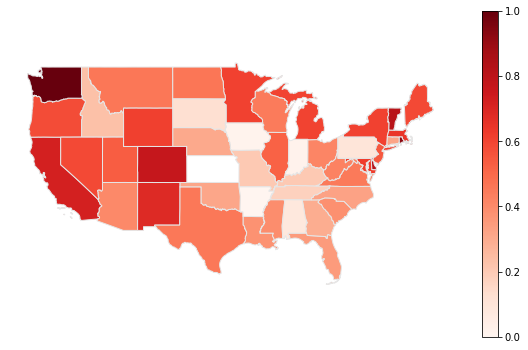

In [142]:
fig, ax = plt.subplots(1, figsize=(10,6))
geo_rel.plot(column='log_rel_norm', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
plt.show()

### Interactive map grouping all the infos

In [143]:
import chart_studio.plotly as py
import plotly.offline as po
import plotly.graph_objs as pg
po.offline.init_notebook_mode(connected=True)

import plotly.express as px
import plotly.graph_objects as go

In [280]:
map_data=pd.merge(total, relative[['rel','log_rel','log_rel_norm']], how='left', on='state')


In [281]:
map_data=pd.merge(map_data, scores, on='state')
map_data=pd.merge(map_data, states[['STUSPS','state']], on='state')


In [282]:
map_data=pd.merge(map_data, emissions_2018[['log_co2_norm','state','Co2_cap']], on='state')


In [283]:
map_data['party'].replace('Republican Party', 0, inplace=True)
map_data['party'].replace('Democratic Party', 1, inplace=True)


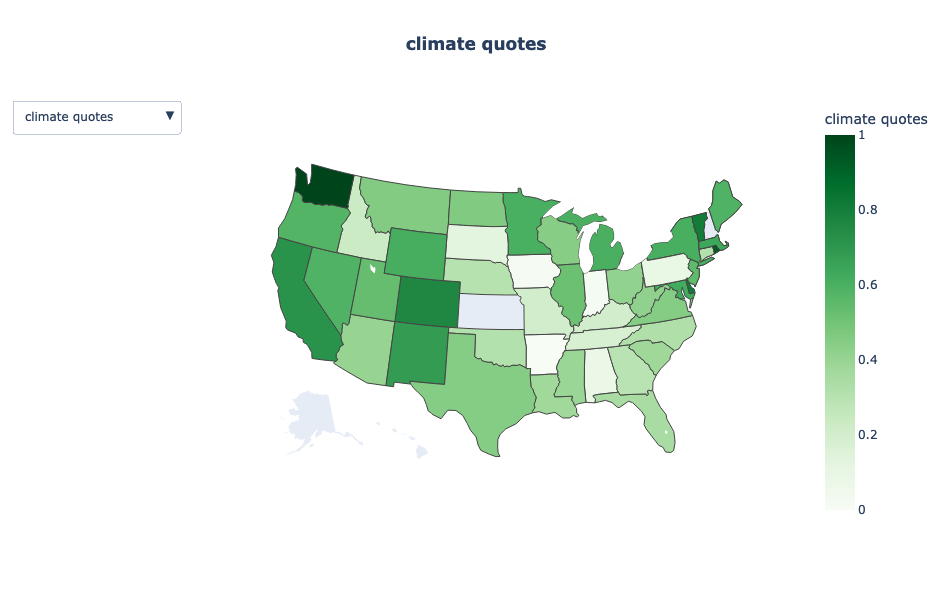

In [291]:
##  After reading this post: https://stackoverflow.com/questions/61750811/dropdown-menu-for-plotly-choropleth-map-plots

map_data = map_data.rename(columns={'log_rel_norm':"climate quotes", 'score':'environmental score', 'log_co2_norm':'CO2 emissions'})
cols_dd = [ "climate quotes", 'environmental score','CO2 emissions']
visible = np.array(cols_dd)

# define traces and buttons
traces = []
buttons = []

for value in cols_dd:
    traces.append(go.Choropleth(
        locations=map_data['STUSPS'], # Spatial coordinates
        z=map_data[value], # Data to be color-coded
        locationmode = 'USA-states',
        colorscale = 'Greens', 
        text = map_data['state'],
        hovertemplate = " %{text} <br> %{z} <extra></extra>",
        colorbar_title=value,
        visible= True if value==cols_dd[0] else False))
    
    buttons.append(dict(label=value,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"<b>{value}</b>"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]

layout = dict(geo = dict(scope='usa'), updatemenus=updatemenus)
# Show figure
fig = go.Figure(data=traces,
                layout=layout)

first_title = cols_dd[0]
fig.update_layout(title=f"<b>{first_title}</b>",title_x=0.5, width=1000,
    height=600)
fig.show()

In [ ]:
###

In [285]:
bar_data=map_data.drop_duplicates(subset=['state'])
bar_data=bar_data.sort_values(['climate quotes'], ascending=False)

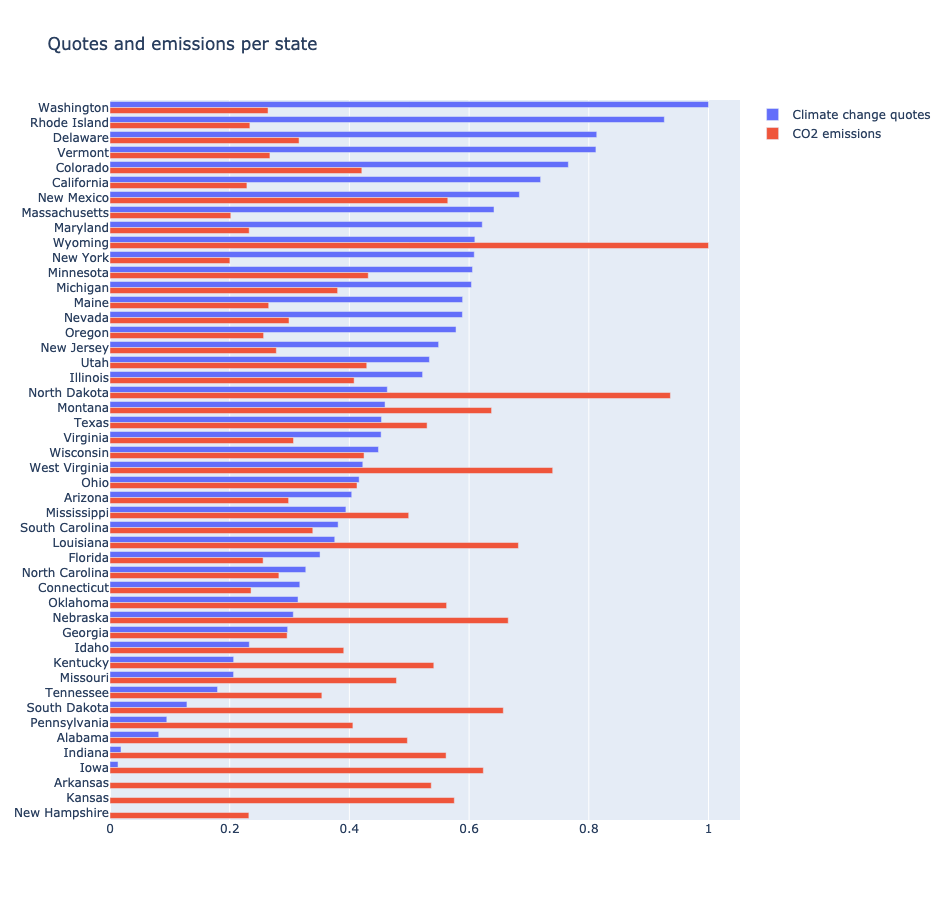

In [286]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    y=bar_data['state'],
    x=bar_data['climate quotes'],
    name='Climate change quotes',
    orientation='h',
    )
)
fig.add_trace(go.Bar(
    y=bar_data['state'],
    x=bar_data['CO2 emissions'],
    name='CO2 emissions',
    orientation='h',
   
    )
)

fig.update_layout(barmode='group', yaxis=dict(autorange='reversed'), width=800, height=900, title='Quotes and emissions per state')
fig.show()
fig.write_html("bar_chart.html")

### Linear regression

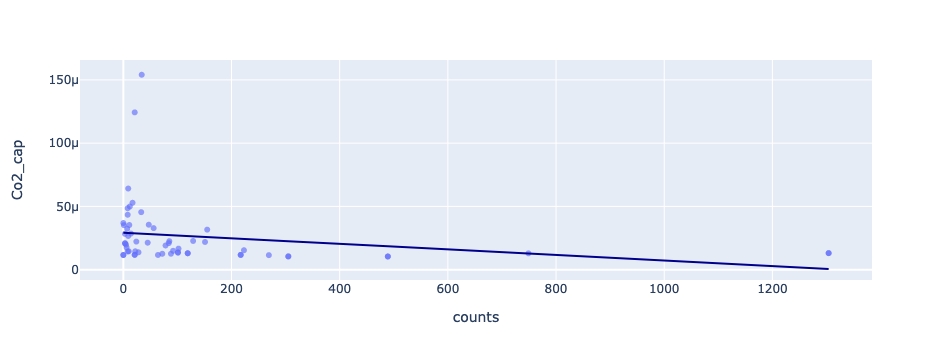

In [290]:
import plotly.express as px

fig = px.scatter(
    map_data, x='counts', y='Co2_cap', opacity=0.65, hover_data=['state'],
    trendline='ols', trendline_color_override='darkblue'
)
fig.show()


In [153]:
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [289]:
stats.spearmanr(map_data['counts'],map_data['Co2_cap'])


SpearmanrResult(correlation=-0.47525941561468665, pvalue=0.00018711308643707132)

In [ ]:
stats.pearsonr(map_data['counts'],map_data['Co2_cap'])

In [155]:
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
mod = smf.ols(formula='score ~ logarithm_count', data=regression_data)


In [ ]:
np.random.seed(2)
res = mod.fit()

In [ ]:
print(res.summary())